## installing necessary libraries and packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

## Loading Dataframe

In [2]:
df = pd.read_csv('AEP_hourly.csv')



In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the DataFrame by 'Datetime' column in ascending order (default)
df = df.sort_values(by='Datetime')



## ACF & PACF plot

<Figure size 1200x600 with 0 Axes>

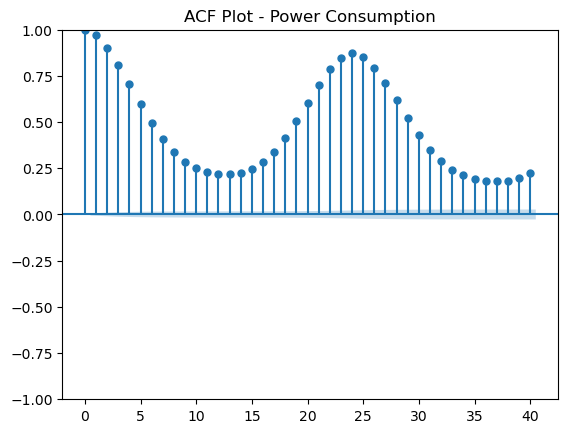

<Figure size 1200x600 with 0 Axes>

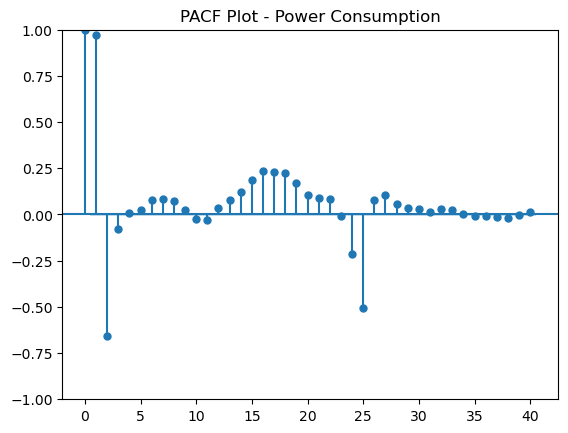

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

df = pd.read_csv('AEP_hourly.csv')

# Ensure the 'Datetime' column is set as the index (optional but useful for time series analysis)

df.set_index('Datetime', inplace=True)

# Plotting the ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(df['AEP_MW'], lags=40)  # You can adjust the number of lags
plt.title('ACF Plot - Power Consumption')
plt.show()

# Plotting the PACF (Partial Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(df['AEP_MW'], lags=40)  # You can adjust the number of lags
plt.title('PACF Plot - Power Consumption')
plt.show()

## By observing the plots, we need to process the data (Differencing)

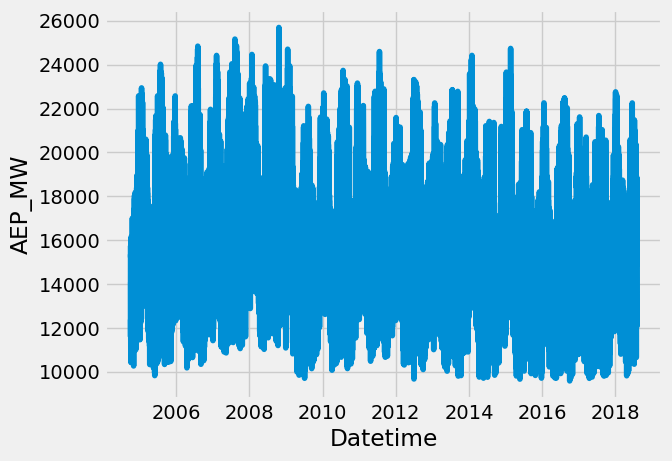

In [38]:
# Plot with Date on the X-axis explicitly
plt.plot(df['Datetime'], df['AEP_MW'])
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.show()

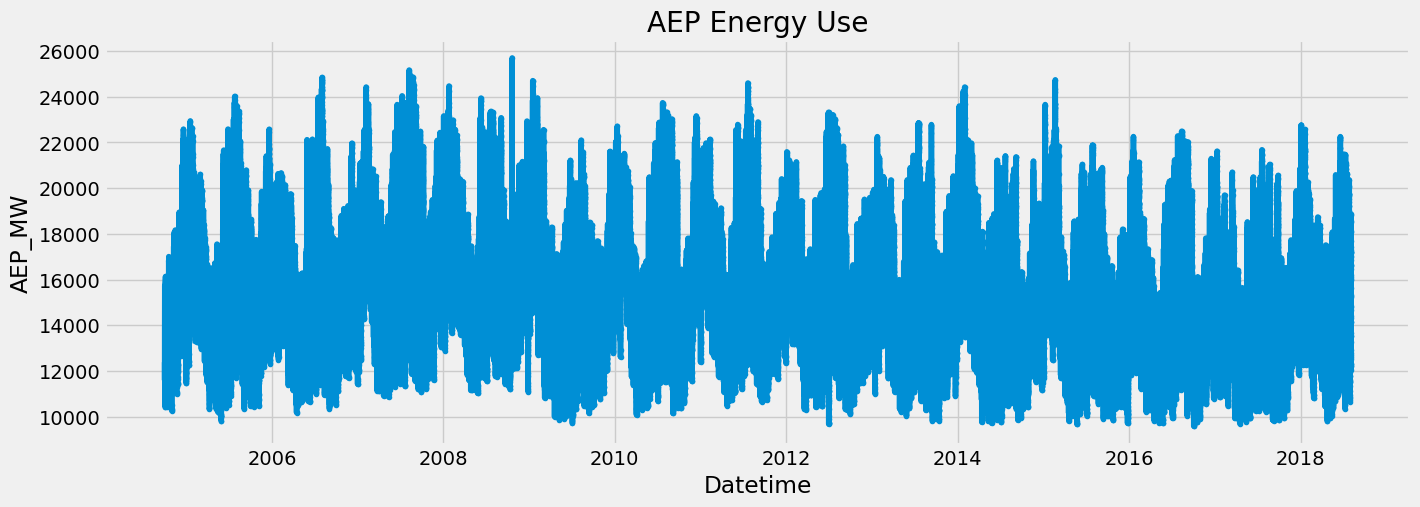

In [47]:

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

# Plotting the 'AEP_MW' data against 'Datetime'
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Datetime'], df['AEP_MW'], marker='.', color=color_pal[0])  # Use the first color from the palette

# Set the labels and title
ax.set_xlabel('Datetime')
ax.set_ylabel('AEP_MW')
ax.set_title('AEP Energy Use')

# Show the plot
plt.show()

## This data is seasonal 

## Hence we can go with two methods
### 1. Xgboost 
### 2. SARIMAX


## 1. Xgboost

### Data Splitting

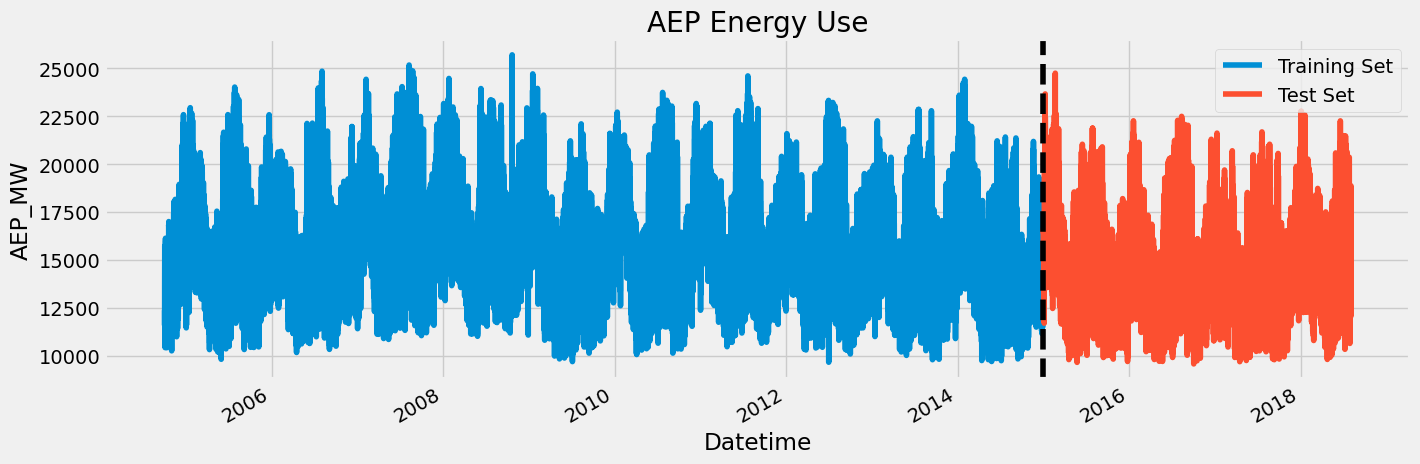

In [48]:
train = df.loc[df['Datetime'] < '2015-01-01']
test = df.loc[df['Datetime'] >= '2015-01-01']


fig, ax = plt.subplots(figsize=(15,5))
train.plot(x='Datetime',y='AEP_MW',ax=ax, label='Training Set')
test.plot(x='Datetime',y='AEP_MW',ax=ax, label = 'Test Set')

#add line 
ax.axvline(pd.to_datetime('2015-01-01'), color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('Datetime')
ax.set_ylabel('AEP_MW')
ax.set_title('AEP Energy Use')

ax.legend()

plt.show()

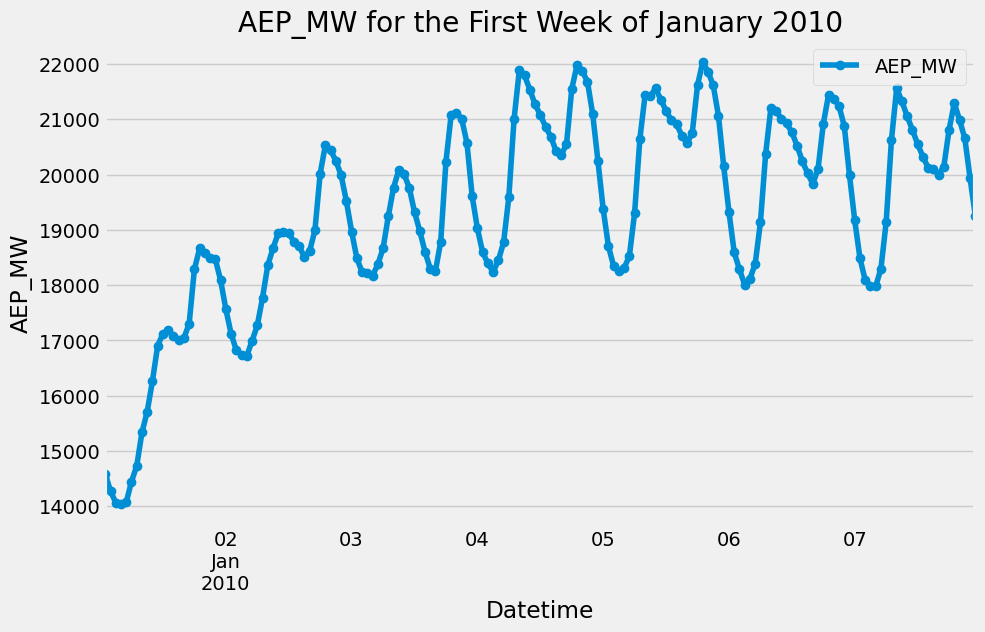

In [51]:
# Filter the data by date range
filtered_data = df.loc[(df['Datetime'] > '2010-01-01') & (df['Datetime'] < '2010-01-08')]

# Plot the filtered data
filtered_data.plot(x='Datetime', y='AEP_MW', marker='o', figsize=(10,6))

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.title('AEP_MW for the First Week of January 2010')

# Show the plot
plt.show

## Feature Creation

In [53]:
# Set 'Datetime' as the index

df.set_index('Datetime', inplace=True)

df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week

In [56]:
df['quarter'] = df.index.quarter

In [57]:
df['month'] = df.index.month
df['year'] = df.index.year

In [60]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004
2004-10-01 02:00:00,11935.0,2,4,4,10,2004
2004-10-01 03:00:00,11692.0,3,4,4,10,2004
2004-10-01 04:00:00,11597.0,4,4,4,10,2004
2004-10-01 05:00:00,11681.0,5,4,4,10,2004


C:\Users\shree02\AppData\Local\Temp\ipykernel_15756\2480225469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues', ax=ax)


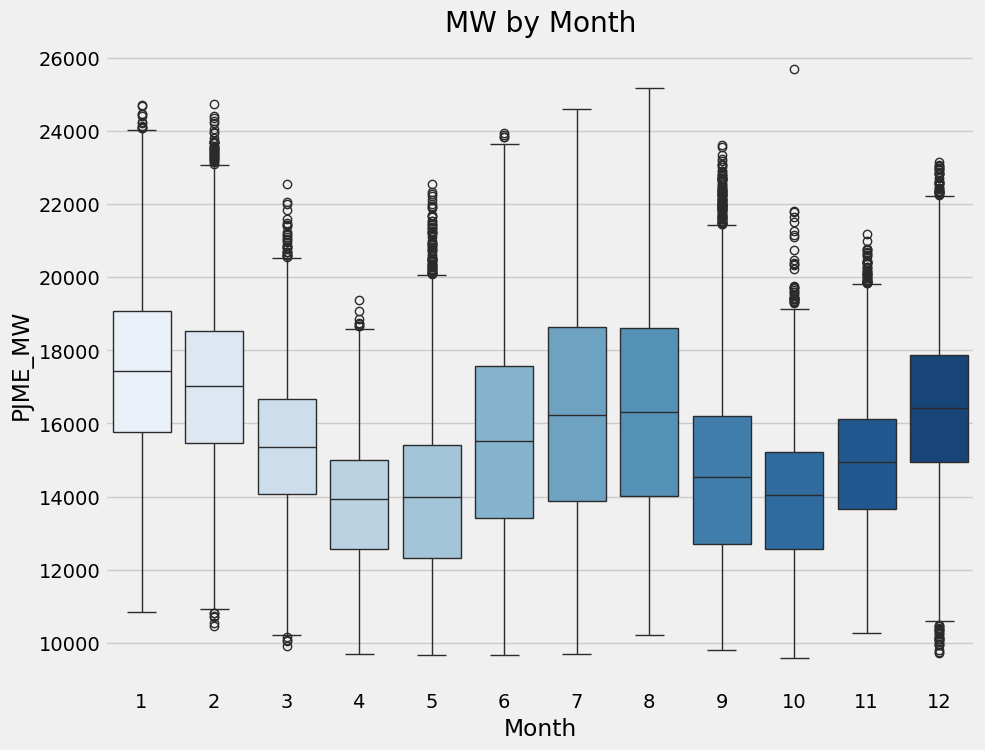

In [65]:
# Create the plot



fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues', ax=ax)

# Set title and labels
ax.set_title('MW by Month')
ax.set_xlabel('Month')
ax.set_ylabel('PJME_MW')

# Show the plot
plt.show()

## Creating Model

In [66]:
from sklearn.metrics import mean_squared_error

In [81]:
from sklearn.model_selection import train_test_split

df = df.reset_index()

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['day'] = df['Datetime'].dt.day

train = df.loc[df['Datetime'] < '2015-01-01']
test = df.loc[df['Datetime'] >= '2015-01-01']



In [82]:
df.head()

,index,Datetime,AEP_MW,hour,dayofweek,quarter,month,year,day
0,0,2004-10-01 01:00:00,12379.0,1,4,4,10,2004,1
1,1,2004-10-01 02:00:00,11935.0,2,4,4,10,2004,1
2,2,2004-10-01 03:00:00,11692.0,3,4,4,10,2004,1
3,3,2004-10-01 04:00:00,11597.0,4,4,4,10,2004,1
4,4,2004-10-01 05:00:00,11681.0,5,4,4,10,2004,1


In [83]:
 #Feature Columns
 FEATURES = ['year','month','day','dayofweek','hour']
    
#Define the target column
 TARGET = 'AEP_MW'
    
# Split features (X) and target (y) for training and testing
# Split the features (X) and target (y) for training and testing
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [90]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:2557.44154	validation_1-rmse:2670.37844
[100]	validation_0-rmse:1702.86530	validation_1-rmse:1941.89766
[200]	validation_0-rmse:1438.06790	validation_1-rmse:1759.89892
[300]	validation_0-rmse:1324.90520	validation_1-rmse:1708.96478
[400]	validation_0-rmse:1248.19016	validation_1-rmse:1691.49642
[500]	validation_0-rmse:1185.07116	validation_1-rmse:1678.28764
[600]	validation_0-rmse:1136.02572	validation_1-rmse:1671.01141
[643]	validation_0-rmse:1120.09080	validation_1-rmse:1671.58493


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [92]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])

In [93]:
fi

,importance
year,0.070858
month,0.190965
day,0.034729
dayofweek,0.235789
hour,0.467659


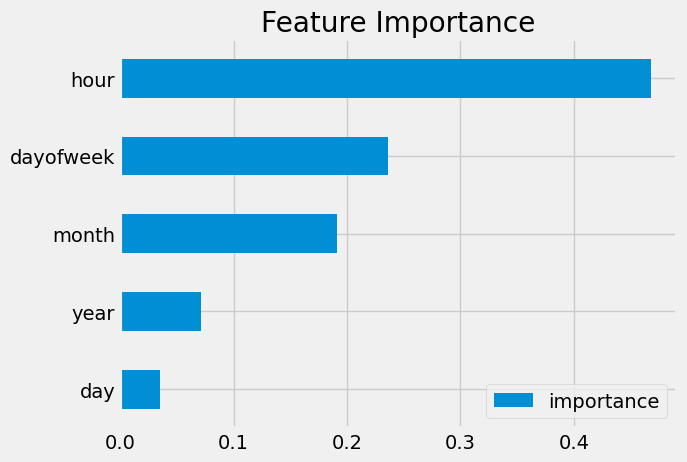

In [94]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()


C:\Users\shree02\AppData\Local\Temp\ipykernel_15756\3663160840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


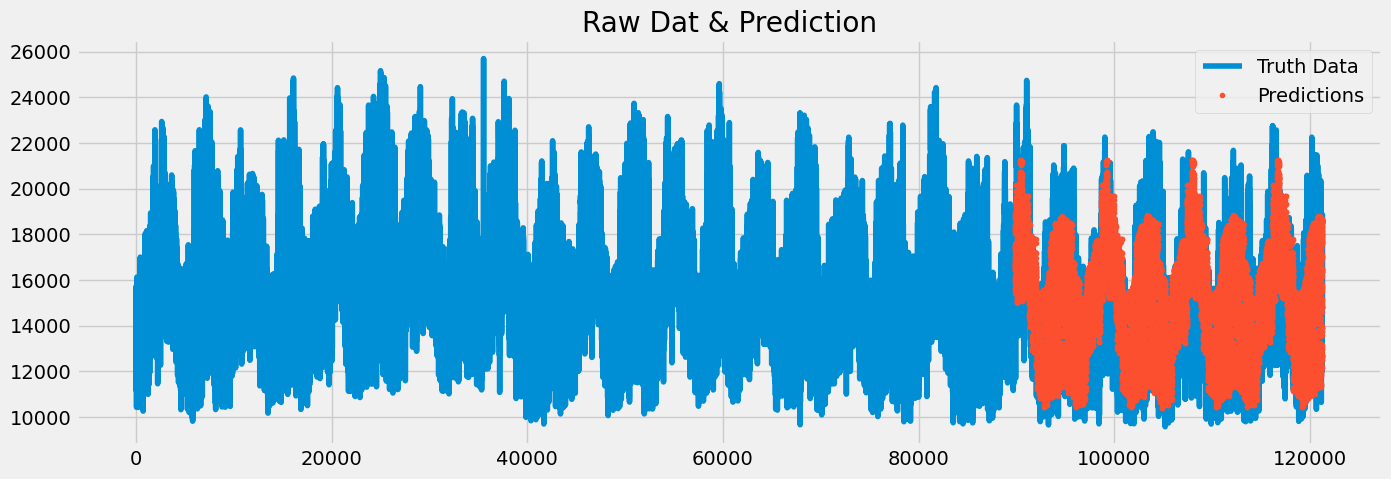

In [95]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat & Prediction')
plt.show()
             

In [100]:
df.head()

,index,Datetime,AEP_MW,hour,dayofweek,quarter,month,year,day,prediction
0,0,2004-10-01 01:00:00,12379.0,1,4,4,10,2004,1,NaN
1,1,2004-10-01 02:00:00,11935.0,2,4,4,10,2004,1,NaN
2,2,2004-10-01 03:00:00,11692.0,3,4,4,10,2004,1,NaN
3,3,2004-10-01 04:00:00,11597.0,4,4,4,10,2004,1,NaN
4,4,2004-10-01 05:00:00,11681.0,5,4,4,10,2004,1,NaN


In [97]:
df.tail()

,index,Datetime,AEP_MW,hour,dayofweek,quarter,month,year,day,prediction
121268,121268,2018-08-02 20:00:00,17673.0,20,3,3,8,2018,2,18131.388672
121269,121269,2018-08-02 21:00:00,17303.0,21,3,3,8,2018,2,17976.396484
121270,121270,2018-08-02 22:00:00,17001.0,22,3,3,8,2018,2,17774.652344
121271,121271,2018-08-02 23:00:00,15964.0,23,3,3,8,2018,2,16477.125000
121272,121272,2018-08-03 00:00:00,14809.0,0,4,3,8,2018,3,14803.868164


In [101]:
df1=df.drop(columns=['prediction'])

## FORECAST FOR NEXT YEAR

In [102]:
# 1. Generate future dates
# Start by creating a date range for the next year (2019)
future_dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='H')

# 2. Create features for the future dates
future_data = pd.DataFrame(future_dates, columns=['Datetime'])

# Extract the same features (year, month, day, dayofweek, hour) from the future dates
future_data['year'] = future_data['Datetime'].dt.year
future_data['month'] = future_data['Datetime'].dt.month
future_data['day'] = future_data['Datetime'].dt.day
future_data['dayofweek'] = future_data['Datetime'].dt.dayofweek
future_data['hour'] = future_data['Datetime'].dt.hour

# 3. Select the features for prediction
future_features = future_data[FEATURES]

# 4. Make predictions for the next year using the trained model
future_predictions = reg.predict(future_features)

# 5. Add predictions back to the future data
future_data['predictions'] = future_predictions

C:\Users\shree02\AppData\Local\Temp\ipykernel_15756\2081015256.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='H')


In [103]:
future_data

,Datetime,year,month,day,dayofweek,hour,predictions
0,2019-01-01 00:00:00,2019,1,1,1,0,16178.021484
1,2019-01-01 01:00:00,2019,1,1,1,1,15646.946289
2,2019-01-01 02:00:00,2019,1,1,1,2,15447.619141
3,2019-01-01 03:00:00,2019,1,1,1,3,15543.890625
4,2019-01-01 04:00:00,2019,1,1,1,4,15543.890625
...,...,...,...,...,...,...,...
8732,2019-12-30 20:00:00,2019,12,30,0,20,17144.687500
8733,2019-12-30 21:00:00,2019,12,30,0,21,17144.687500
8734,2019-12-30 22:00:00,2019,12,30,0,22,16880.199219
8735,2019-12-30 23:00:00,2019,12,30,0,23,16228.539062


In [105]:
future_data.to_csv('AEP_forecast(2019).csv', index=False)